## **Multi agent implement using `LangGraph` on `airflow_etltest` Database**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_huggingface import HuggingFaceEmbeddings

## **Importing `Embedding` and `ChatGroq llm`**

In [14]:
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

llm = ChatGroq(model=os.getenv("QWEN_MODEL"))

## Test llm
llm.invoke("test line")

AIMessage(content='<think>\nOkay, the user sent "test line". I need to respond appropriately. Since it\'s a test, maybe they just want to see how I react. I should acknowledge their test message and offer help. Let me check if there\'s any specific context, but there\'s none. So a simple, friendly response should work. Maybe something like, "Hello! It looks like you\'re testing. How can I assist you today?" That\'s open-ended and invites them to ask a real question if they have one.\n</think>\n\nHello! It looks like you\'re testing. How can I assist you today? Feel free to ask any questions or let me know if you need help with anything specific! 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 144, 'prompt_tokens': 10, 'total_tokens': 154, 'completion_time': 0.276949577, 'prompt_time': 0.000204698, 'queue_time': 0.048727252, 'total_time': 0.277154275}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'finish_reason': 'stop', 'logpr

# **Multi Agent Workflow Start**

### **Connect To database using `pands read_sql`**

In [4]:
import mysql.connector
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='airflow_etltest'
)

## **Create sql engine**

In [5]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://root:@localhost/airflow_etltest')

## **Testing Query Run On the Database**

In [6]:
from sqlalchemy import text
import pandas as pd

# Your target account holder name
first_name = "John"

# Updated query (table: Employee, column: first_name)
query = text("SELECT * FROM employee WHERE first_name = :first_name")

# Run the query using SQLAlchemy engine
df = pd.read_sql(query, con=engine, params={"first_name": first_name})

# Extract the first result as string context (optional)
context_str = df.iloc[0].to_string()
context_str


'employee_id                        1\nfirst_name                      John\nlast_name                        Doe\nemail           john.doe@example.com\nphone_number            123-456-7890\nhire_date                 2023-01-15\njob_title          Software Engineer\nsalary                       75000.0'

## **SQL Query Generation based on user Question**

In [7]:
from pydantic import BaseModel, Field
from typing import Optional

class QueryAnalysis(BaseModel):
    """
    Analyzes the user's question to determine if a SQL query can be generated
    and provides the query if possible.
    """
    query_is_possible: bool = Field(
        ..., # ... means this field is required
        description="Set to true if the question can be answered with a SQL query based on the schema, false otherwise."
    )
    sql_query: Optional[str] = Field(
        default=None,
        description="The generated MySQL query. This MUST be null or empty if query_is_possible is false."
    )
    reason: str = Field(
        ...,
        description="A brief, user-facing explanation of why the query is or is not possible. E.g., 'The user is engaging in a general greeting.' or 'The query is possible and targets customer outstanding balances.'"
    )

# And update the parser


In [8]:
from langchain_core.output_parsers import PydanticOutputParser
query_analysis_parser = PydanticOutputParser(pydantic_object=QueryAnalysis)

### **Query Generation Prompt**

In [9]:
from langchain_core.prompts import PromptTemplate

sql_query_prompt = PromptTemplate(
    template="""
You are an expert MySQL developer and a helpful assistant. Your primary task is to first analyze a user's question to determine if it can be answered using the provided database schema. Then, if and only if it's possible, you must convert the question into an accurate and efficient MySQL query.

---
### DATABASE SCHEMA AND TABLE GUIDE
[... The entire "DATABASE SCHEMA" and "QUERYING INSTRUCTIONS" sections from the previous prompt remain exactly the same here ...]
---
### ANALYSIS AND RESPONSE INSTRUCTIONS

You must first analyze the user's question and then respond in the required JSON format.

1.  **Analyze Intent:** Read the user's question. Is it a request for data that exists in the database schema (customers, vendors, invoices, payments, etc.)? Or is it a general greeting, a nonsensical question, or a request for information outside the database's scope?

2.  **Set `query_is_possible` flag:**
    - Set to `true` if the question is a valid request for data.
    - Set to `false` if it's a greeting, unrelated, or cannot be answered from the schema.

3.  **Generate `sql_query`:**
    - If `query_is_possible` is `true`, generate the correct MySQL query.
    - If `query_is_possible` is `false`, the `sql_query` field MUST be `null`.

4.  **Provide a `reason`:**
    - Briefly explain your decision. This helps in understanding the context.

---
### EXAMPLES

**Example 1: Valid Question**
- **User question:** "Show me the aging details for all customers located in Colombo"
- **Your JSON output:**
  ```json
  {{
    "query_is_possible": true,
    "sql_query": "SELECT * FROM CustomerSiteListingUpdated c JOIN Modified_Debtors_Statement d ON c.site_number = d.account_number WHERE c.city = 'Colombo';",
    "reason": "The user is asking for customer aging data for a specific city, which can be found by joining the customer and debtor tables."
  }}
  
Example 2: Invalid Question
User question: "Hey, what's up?"
Your JSON output:
  
  {{
  "query_is_possible": false,
  "sql_query": null,
  "reason": "The user is engaging in a general greeting, not asking a question about the database."
  }}
Example 3: Unanswerable Question
User question: "Who is the CEO of United Parcel Service?"
Your JSON output:
  {{
  "query_is_possible": false,
  "sql_query": null,
  "reason": "The database contains invoice and vendor information for 'United Parcel Service' but does not include details about their corporate structure like CEO names."
  }}
  
Now, based on all the information above, analyze the following user question and provide your response in the specified JSON format.
User question:
{question}
{format_instruction}
""",
input_variables=["question"],
partial_variables={
"format_instruction": query_analysis_parser.get_format_instructions()
}
)

In [10]:
from pydantic import BaseModel, Field
from typing import Annotated

from pydantic import BaseModel, Field
from typing import Annotated

class SqlQuery(BaseModel):
    """This class is responsible for writing SQL queries for airflow_etltest Database."""
    sql_query: Annotated[str, Field(description="Based on the user question, convert into the SQL query.")]

In [11]:
from langchain_core.output_parsers import PydanticOutputParser
sql_query_parser = PydanticOutputParser(pydantic_object=SqlQuery)

In [12]:
from langchain_core.prompts import PromptTemplate
sql_query_prompt = PromptTemplate(
    template="""
You are an expert MySQL developer specializing in financial and business data analysis. Your primary task is to convert a user's natural language question into an accurate and efficient MySQL query based on the database schema provided below.

The database contains information about customers, suppliers, invoices, payments, and debit memos. It is a relational database, and you **must** use JOINs to connect tables to answer questions comprehensively.

---
### DATABASE SCHEMA AND TABLE GUIDE


**1. Customer & Site Information**
   - **Primary Table:** `customersitelistingupdated`
   - **Purpose:** Contains the master list of customers and their site details. PREFER this table over `customersitelisting`.
   - **Key Columns:** `maincustomer_name`, `site_number`, `customer_type`, `city`, `address1`.
   - **Note:** This table contains standardized columns like `maincustomer_name_lower`. Use these for case-insensitive matching.

**2. Debtor / Accounts Receivable (AR) Information**
   - **Primary Table:** `Modified_Debtors_Statement`
   - **Purpose:** Provides a customer aging report, showing outstanding amounts in different time buckets. PREFER this over `debtors_statement_aging_query`.
   - **Key Columns:** `account_number`, `account_name`, `outstanding_amount`, `d0_30`, `d31_45`, `d46_60`, etc.
   - **Other Relevant Tables:** `debitmemolisting` (for debit memos), `debtorsstatementreportQ4` (for credit notes).

**3. Supplier & Invoice Information**
   - **Primary Table:** `supplierdetails`
   - **Purpose:** Contains detailed information about supplier invoices. It has many useful standardized columns.
   - **Key Columns:** `vendor_name`, `invoice_id`, `invoice_num`, `invoice_date`, `invoice_amount`, `amount_paid`, `balance_remaining`.
   - **Other Relevant Tables:** `supplierinvoicepaymentdetails` is also a key table for invoice data.

**4. Supplier Payment Information**
   - **Primary Table:** `supplierspaymenthistoryupdated`
   - **Purpose:** Details about payments made against supplier invoices. PREFER this over other `supplierpaymenthistory` tables.
   - **Key Columns:** `c_invoice_number`, `c_payment_amount`, `c_invoice_date`.

---
### QUERYING INSTRUCTIONS AND BEST PRACTICES

1.  **JOINs are Essential:** You MUST use JOINs to link data across tables. Here are the most common join keys:
    - **Customer to Debtor:** `customersitelistingupdated.site_number` = `modified_debtors_statement.account_number`
    - **Supplier Invoices to Payments:** `supplierdetails.invoice_num` = `supplierspaymenthistoryupdated.c_invoice_number`
    - You can also join on name fields like `maincustomer_name` and `account_name` if needed, but IDs are preferred.

2.  **Table Preference:** When multiple similar tables exist, **always prefer the 'Updated' or 'Modified' version** (e.g., use `customersitelistingupdated`, not `customersitelisting`).

3.  **Column Selection:** To provide maximum context for the final answer, **always use `SELECT *`**. The downstream application will handle the formatting of the results. Do not try to select specific columns unless the user explicitly asks for a count or a sum of a single column.

4.  **String/Name Matching:** For queries involving customer or supplier names, perform a case-insensitive search. Use the lowercase standardized columns (e.g., `maincustomer_name_lower`, `vendor_name_lower`) and the `LIKE` operator. Convert the name from the user's query to lowercase. For example: `WHERE maincustomer_name_lower LIKE '%acme corp%'`.

5.  **Dates:** When a user asks for a specific date or date range, use the relevant date columns (`trx_date`, `invoice_date`, etc.). Assume dates are in 'YYYY-MM-DD' format.

6.  **Analyze the Question:** Carefully read the user's question to determine the core intent.
    - If it's about a "customer" and "outstanding balance", you'll need to join `customersitelistingupdated` and `modified_debtors_statement`.
    - If it's about a "supplier" and "payments", you'll need to join `supplierdetails` and `SuppliersPaymentHistoryUpdated`.
    - If it's just about "invoice details", `supplierdetails` alone might be sufficient.

---
### EXAMPLES

- **User question:** "Find all sites for customer 'Global Trade Inc'" 
    

- **User Query:** "Find all sites for customer 'Global Trade Inc'"
- **SQL Query:** `SELECT * FROM customersitelistingupdated WHERE maincustomer_name_lower LIKE '%global trade inc%';`



- **User Query:** "What is the total outstanding amount for customer account number 112233?"
- **SQL Query:** `SELECT * FROM modified_debtors_statement WHERE account_number = '112233';`

- **User Query:** "Show me the aging details for all customers located in Colombo"
- **SQL Query:** `SELECT * FROM customersitelistingupdated c JOIN modified_debtors_statement d ON c.site_number = d.account_number WHERE c.city = 'Colombo';`

- **User Query:** "List all invoices and their payment status for the supplier 'Innovate Supplies'"
- **SQL Query:** `SELECT * FROM supplierdetails s LEFT JOIN supplierspaymenthistoryupdated p ON s.invoice_num = p.c_invoice_number WHERE s.vendor_name_lower LIKE '%innovate supplies%';`

---

Now, based on all the information above, generate the MySQL query for the following user question.
## one more things is in my database all table and column name is lowercase.

**User question:**
{question}

{format_instruction}
""",
    input_variables=["question"],
    partial_variables={
        "format_instruction": sql_query_parser.get_format_instructions()
    }
)

## **Chain forming**

In [17]:
sql_query_writer_chain = sql_query_prompt | llm | sql_query_parser

## Test query
response = sql_query_writer_chain.invoke("What is the invoice amount for the invoice with ID 10070?")
response.sql_query

"SELECT * FROM supplierdetails WHERE invoice_id = '10070';"

## **Test Query**

In [18]:
df = pd.read_sql(response.sql_query, con=engine)

In [19]:
df

,invoice_id,invoice_num,invoice_num_standard,invoice_num_upper,invoice_num_lower,last_update_date,last_updated_by,vendor_id,set_of_books_id,invoice_currency_code,...,remit_to_supplier_site_lower,remit_to_supplier_site_id,vendor_name,vendor_name_standard,vendor_name_upper,vendor_name_lower,segment1,invoice_amount,amount_paid,balance_remaining
0,10070,6181-1,6181-1,6181-1,6181-1,1996-01-07 11:31:41,1006,1,1,USD,...,ge plastics,1,GE Plastics,GE Plastics,GE PLASTICS,ge plastics,1000,900.0,900.0,0.0


## **Now building the Multi Agent**

In [20]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage
from pydantic import Field
import operator

class State(TypedDict):
    """This is is my graph state where store all conversations."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    raw_data: Annotated[str, Field(description="This raw data extract form MySQL DB")]

In [21]:
def data_extraction(state: State):
    print("--Data extraction--")
    
    # Get the latest user message
    question = state["messages"][-1]
    
    # Generate SQL query from user input using the LLM chain
    print("--Generate sql query--")
    response = sql_query_writer_chain.invoke(question)
    query = response.sql_query
    print("--SQL query generation done--")
    
    ## sql query transformation
    if '%' in query:
        query = query.replace('%', '%%')
        
    print(f"Generated SQL Query: {query}")

    print("--data extracting from Database--")
    try:
        # Execute the generated SQL query
        df = pd.read_sql(query, con=engine)

        if df.empty:
            context_str = "No transaction data found for this query."
        else:
            # Convert first row to string as context
            context_str = df.iloc[0].to_string()
    except Exception as e:
        context_str = f"Error while querying the database: {str(e)}"

    print("---Data extraction done---")
    
    return {
        "raw_data": context_str
    }


In [22]:
query = "SELECT SUM(invoice_amount) AS total_invoice_amount FROM supplierdetails WHERE vendor_name_lower LIKE '%ge plastics%';"


if '%' in query:
    query = query.replace('%', '%%')  # escape % for pandas.read_sql
print(query)


df = pd.read_sql(query, con=engine)

df

SELECT SUM(invoice_amount) AS total_invoice_amount FROM supplierdetails WHERE vendor_name_lower LIKE '%%ge plastics%%';


,total_invoice_amount
0,7848159.0


## **Output Generation Prompt**

In [23]:
from langchain_core.prompts import PromptTemplate

output_prompt = PromptTemplate(
    template="""
You are a professional data analyst answering user questions based strictly on provided raw data.

## Instructions:
- Answer the user question using only the context.
- Do not explain anything.
- Do not include extra sentences.
- Do not make up any information.
- If the context is empty or does not contain the answer, respond with:
**"No data available for this query."**
- Output in clean **Markdown** format.
---

User Question:  
{question}

Context:  
{context}
""",
    input_variables=["question", "context"]
)


## ***import small `llm` for response generate***

In [24]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
print(os.getenv("LLAMA_MODEL"))
sml_llm = ChatGroq(model=os.getenv("LLAMA_MODEL"))

sml_llm.invoke("test line")

meta-llama/llama-4-scout-17b-16e-instruct


AIMessage(content="This conversation just started. What's up?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 12, 'total_tokens': 21, 'completion_time': 0.017940005, 'prompt_time': 0.002171936, 'queue_time': 0.046069513, 'total_time': 0.020111941}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_5d3e4e58e1', 'finish_reason': 'stop', 'logprobs': None}, id='run--726146b5-78c2-48cc-a91e-b3a11d7dab36-0', usage_metadata={'input_tokens': 12, 'output_tokens': 9, 'total_tokens': 21})

## **Output Generation Node**

In [25]:
from langchain_core.output_parsers import StrOutputParser

def answer_generate(state: State):
    print("--Output generate Start--")
    question = state['messages'][-1]
    phone_context = state["raw_data"]
    print(question)
    # print(phone_context)
    
    review_chain = output_prompt | sml_llm | StrOutputParser()
    
    print("--Output Generation Done--")
    # response = llm.invoke(question)
    
    response = review_chain.invoke(
        {
            "question": question,
            "context": phone_context
        }
    )
    
    return {
        "messages": [response]
    }

## **Multi agent Workflow**

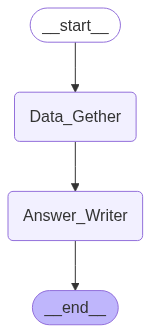

In [26]:
from langgraph.graph import START, END, StateGraph
from IPython.display import display, Image, Markdown

builder = StateGraph(State)

## define node
builder.add_node("Data_Gether", data_extraction)
builder.add_node("Answer_Writer", answer_generate)

## Define edges
builder.add_edge(START, "Data_Gether")
builder.add_edge("Data_Gether", "Answer_Writer")
builder.add_edge("Answer_Writer", END)

app = builder.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
output = app.invoke(
    {
        "messages": ["What is the invoice amount for the invoice with ID 10070?"]
    }
)

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT * FROM supplierdetails WHERE invoice_id = '10070';
--data extracting from Database--
---Data extraction done---
--Output generate Start--
What is the invoice amount for the invoice with ID 10070?
--Output Generation Done--


In [28]:
Markdown(output["messages"][-1])

**$900.0**

In [30]:
output = app.invoke(
    {
        "messages": ["what is the total invoice amount of vendor name ge plastics?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT SUM(invoice_amount) FROM supplierdetails WHERE vendor_name_lower LIKE '%%ge plastics%%';
--data extracting from Database--
---Data extraction done---
--Output generate Start--
what is the total invoice amount of vendor name ge plastics?
--Output Generation Done--


**$7,848,159.00**

In [ ]:
output = app.invoke(
    {
        "messages": ["How many distinct vendor names are there?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT COUNT(DISTINCT vendor_name) FROM supplierdetails;
--data extracting from Database--
---Data extraction done---
--Output generate Start--
How many distinct vendor names are there?
--Output Generation Done--


## Answer
### Distinct Vendor Names
**75**

In [ ]:
output = app.invoke(
    {
        "messages": ["What is the total remaining balance?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT SUM(balance_remaining) FROM supplierdetails;
--data extracting from Database--
---Data extraction done---
--Output generate Start--
What is the total remaining balance?
--Output Generation Done--


**$7,434,848.00**

In [32]:
output = app.invoke(
    {
        "messages": ["What is the name of the vendor for the invoice ID 10209?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT * FROM supplierdetails WHERE invoice_id = '10209';
--data extracting from Database--
---Data extraction done---
--Output generate Start--
What is the name of the vendor for the invoice ID 10209?
--Output Generation Done--


### Vendor Name for Invoice ID10209
* **Vendor Name:** Advantage Corp

In [33]:
output = app.invoke(
    {
        "messages": ["What is the payment method used for the invoice ID 10230?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT * FROM supplierdetails s LEFT JOIN supplierspaymenthistoryupdated p ON s.invoice_num = p.c_invoice_number WHERE s.invoice_id = '10230';
--data extracting from Database--
---Data extraction done---
--Output generate Start--
What is the payment method used for the invoice ID 10230?
--Output Generation Done--


### Payment Method for Invoice ID10230
* **Payment Method Code:** CHECK
* **Payment Method Code Standard:** Check

In [36]:
output = app.invoke(
    {
        "messages": ["What is the total invoice amount for all invoices where the vendor is 'United Parcel Service'?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT SUM(invoice_amount) AS total_invoice_amount FROM supplierdetails WHERE vendor_name_lower LIKE '%%united parcel service%%';
--data extracting from Database--
---Data extraction done---
--Output generate Start--
What is the total invoice amount for all invoices where the vendor is 'United Parcel Service'?
--Output Generation Done--


## Total Invoice Amount
The total invoice amount for all invoices where the vendor is 'United Parcel Service' is not calculable from the provided data.

**No data available for this query.**

In [37]:
output = app.invoke(
    {
        "messages": ["What is the total sum of the invoice amounts for all invoices in the dataset?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT SUM(invoice_amount) AS total_sum FROM supplierdetails;
--data extracting from Database--
---Data extraction done---
--Output generate Start--
What is the total sum of the invoice amounts for all invoices in the dataset?
--Output Generation Done--


**$956,122,127.0**

In [40]:
output = app.invoke(
    {
        "messages": ["What is the average invoice amount for invoices where the payment method is 'CHECK'?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT * FROM supplierdetails s LEFT JOIN supplierspaymenthistoryupdated p ON s.invoice_num = p.c_invoice_number WHERE p.payment_method = 'CHECK';
--data extracting from Database--
---Data extraction done---
--Output generate Start--
What is the average invoice amount for invoices where the payment method is 'CHECK'?
--Output Generation Done--


**No data available for this query.**

In [41]:
output = app.invoke(
    {
        "messages": ["Which vendor has the highest total invoice amount, and what is that amount?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
--Generate sql query--
--SQL query generation done--
Generated SQL Query: SELECT vendor_name_lower AS vendor_name, SUM(invoice_amount) AS total_invoice_amount FROM supplierdetails GROUP BY vendor_name_lower ORDER BY total_invoice_amount DESC LIMIT 1;
--data extracting from Database--
---Data extraction done---
--Output generate Start--
Which vendor has the highest total invoice amount, and what is that amount?
--Output Generation Done--


### Vendor with the Highest Total Invoice Amount

* **Vendor Name:** advanced network devices
* **Total Invoice Amount:** $349,848,560.00